In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

### 1. Loading MNIST data from keras dataset and visualizing
- After pip installing tensorflow, if not installed before, restart the environment.
- The data has been pre-split by default.

In [14]:
# Loading MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Checking shape of data
print(X_train.shape) ## 60,000 images, 28 x 28 size
print(y_train.shape) ## 60,000 labels for each image

(60000, 28, 28)
(60000,)


Visualizing sample images from MNIST dataset:


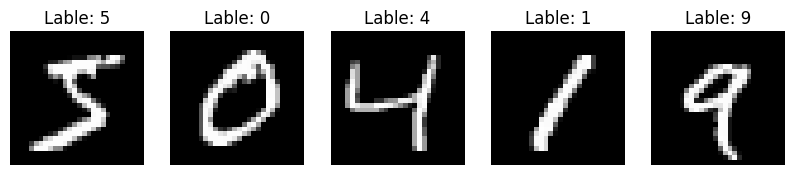

In [8]:
# Function to visualize a few training images
def visualize_samples(X, y, n = 5):
    plt.figure(figsize=(10,2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i], cmap = 'gray')
        plt.title(f"Lable: {y[i]}")
        plt.axis('off')
    plt.show()

print("Visualizing sample images from MNIST dataset:")
visualize_samples(X_train, y_train)


### 2. Preprocessing data, normalizing pixel values
- The datasets are already split and given in an array.
- For MNIST, each pixel value is an integer [0, 255], on a scale from black to white respectively. We are normalizing the data between 0 and 1
- This improves convergence/ convergence speed. Gradients become more uniform, allowing for gradient descent or SGD to be faster.
- Since the shape is 28x28, we have to flatten the datasets into a one-dimensional vector 

In [21]:
# Normalizing data between 0 and 1 
X_train = X_train / 225.0
X_test = X_test / 255.0

# Flattening dataset to be a one-dimensional vector
X_train_flat = X_train.reshape(X_train.shape[0], -1)  ## Shape becomes (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)      ## Shape becomes (10000, 784)

### 3. Initializing parameters and functions
- This prepares the activation functions used in this neural network
- We initialize weights and biases with random values [-0.5, 0.5], preventing network from starting with bias towards any direction.
- Biases can be set at 0 for simplicity. But this could lead to dead neurons that never activate with ReLU.

In [ ]:
# ReLU activation function, returning Z if > 0, returning 0 if =< 0
def ReLU(Z):
    return np.maximum(0, Z)

# ReLU derivative. The ReLU derivative is 1 for Z > 0 and 0 if Z =< 0
def ReLU_deriv():
    return Z > 0 ## Forces a boolean that takes Z > 0 as true (1), Z =< 0 as false (0)

# Softmax activation function
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z))

# Function to initialize Hidden Layer 1 (H1) and Hidden Layer 2 (H2)
def init_params():
    # Initializing weights with random values [-0.5, 0.5]
    W1 = np.random.rand(10, 784) - 0.5 ## H1 consists of 10 hidden neurons, 784 input neurons
    b1 = np.random.rand(10, 1) - 0.5  

    W2 = np.random.rand(10, 10) - 0.5 ## H2 consists of 10 hidden neurons, 10 input neurons from H1
    b2 = np.random.rand(10, 1) - 0.5 
    return W1, b1, W2, b2

# Forward propogation - Activation Function 1 (A1) uses ReLU and Activation Function 2 (A2) uses Softmax
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(A1)
    return Z1, A1, Z2, A2)

# Don't really quite understand this yet
def one_hot(Y):
    one_hot_Y = np.zeroes((Y.size, Y.max() + 1))
    one_hot_Y[np.arrange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Back propogation
def back_prop(Z1, A1, Z2, A2):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, 2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ2.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, 2)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    